# **Chap7：自然语言处理**

In [1]:
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import collections
from source.code import ch7
from source.code import utils
import time
import os

2023-06-19 19:22:41.459897: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 19:22:41.650411: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-19 19:22:41.712780: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-19 19:22:43.046438: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# 如果你要在服务器上和别人共用GPU，可以设置你需要的显存资源
utils.gpu_limitation_config(memory=30,device=1)

## **7.4 单文本和多文本任务**

我们在本节展示多种自然语言处理任务及丰富的模型架构，**NLP 任务，以及处理这些任务的模型的架构都很灵活**，但从任务类型上，我们本节关注两大类：**单文本任务**和**多文本任务**
* **单文本任务**：模型输入是一个文本序列，我们需要综合整个序列的信息，基于这个序列做出判断或预测
* **多文本任务**：模型输入**通常是一对文本序列**，或甚至多条文本序列，这种类型的任务一般考虑多条文本间的逻辑关系，或其他交互

NLP 灵活的模型架构也可以进行抽象，通常可以**拆解为两个部分**：
* **编码器**：第一个部分，我们通常会利用词嵌入技术，将文本序列中的词元嵌入到词向量，例如 `word2vec`，`GloVe`，`BERT`
* **下游任务**：根据不同的任务类型和模型假设，建立下游任务网络，然后**将词嵌入向量作为下游网络的输入**

### **7.4.1 单文本任务**

我们这里一种基础的 NLP 单文本入门任务：**情感分析**，我们可以从感兴趣的互联网平台上收集大量的文本（例如商品评论，电影评论，短视频评论，公众号评论等），这些评论都包含了人们大量的情绪信息，**情感分析在政治（公众政策情绪分析）、金融（市场情绪分析）、营销（产品和品牌管理）等领域很有价值**


我们以**斯坦福大学的大型电影评论数据集为例做情感分析**，它包含一个训练集和一个测试集，包含从 IMDb 下载的 25000 条电影评论，每个文本被赋予 **积极** 和 **消极** 两种标签，且两类样本数量相同

文件保存在路径 `../source/data/text/aclImdb`，目录结构为：
* `aclImdb`
  * `train`
    * `pos`
    * `neg`
  * `test`
    * `pos`
    * `neg`

In [4]:
def read_imdb(path : str, dataset : str="train"):
    # 初始化数据和标签列表
    data, labels = [], []

    # 拼接路径
    path = os.path.join(path, dataset)
    for label in ["pos", "neg"]:
        sub_path = os.path.join(path, label)
        # 读取文件夹下的所有文件
        for file in os.listdir(sub_path):
            with open(os.path.join(sub_path, file), "r", encoding="utf-8") as f:
                # 读取文件内容
                text = f.read()
                data.append(text)
                labels.append(0 if label == "neg" else 1)
    return data, labels

In [5]:
path = "../source/data/text/aclImdb/"
train_data, train_labels = read_imdb(path, dataset="train")
print("训练集样本量：", len(train_data))
print("第一个样本部分序列：", train_data[0][:80])
print("第一个样本标签：", train_labels[0])

训练集样本量： 25000
第一个样本部分序列： I am not going to spoil the contents to anyone, who has not yet watched this hum
第一个样本标签： 1


#### **数据集预处理**

与通常的 NLP 任务一样，我们需要先对文本做**词元化**，**创建词表**，**统计序列长度的分布情况**，**然后选择何时长度做截断和填充**

Text(0, 0.5, 'frequency')

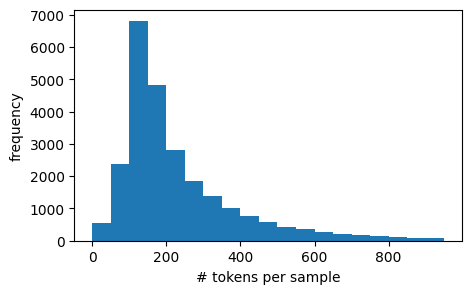

In [6]:
# 词元化并创建词表
train_tokens = utils.english_tokenize(train_data,token="word")
vocab = utils.Vocab(train_tokens, min_freq=5)
# 绘制序列长度分布图
fig = plt.figure(figsize=(5, 3))
plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50))
plt.xlabel('# tokens per sample')
plt.ylabel('frequency')

超过 80% 以上的句子长度小于 300，我们可以设定 `num_steps = 300`，对句子进行填充和截断

In [8]:
# 填充和截断
num_steps = 300
train_features = tf.constant([
    vocab[utils.truncate_padding(line, num_steps, vocab["<pad>"])] for line in train_tokens])
print(train_features.shape)

(25000, 300)


最后，我们整合代码，创建批量数据迭代器

In [67]:
def load_imdb_dataset(path : str, batch_size : int=64, num_steps : int=300):
    # 读取数据
    train_data, train_labels = read_imdb(path, dataset="train")
    test_data, test_labels = read_imdb(path, dataset="test")
    # 词元化
    train_tokens = utils.english_tokenize(train_data, token="word")
    test_tokens = utils.english_tokenize(test_data, token="word")
    # 创建词表
    vocab = utils.Vocab(train_tokens, min_freq=5)
    # 填充和截断
    train_features = tf.constant([
        vocab[utils.truncate_padding(line, num_steps, vocab["<pad>"])] for line in train_tokens])
    test_features = tf.constant([
        vocab[utils.truncate_padding(line, num_steps, vocab["<pad>"])] for line in test_tokens])
    
    # 创建数据集
    train_iter = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
    train_iter = train_iter.shuffle(buffer_size=len(train_features)).batch(batch_size)
    test_iter = tf.data.Dataset.from_tensor_slices((test_features, test_labels))
    test_iter = test_iter.batch(batch_size)

    return train_iter, test_iter, vocab

接下来，我们介绍两种处理情感分析的建模方案，它们将**分别使用 RNN 和 CNN**

**(1) 使用循环神经网络 RNN**

与词相似度和类比任务一样，我们**可以将预先训练的词向量应用于情感分析**，整个模型分为三部分：
* **STEP 1**：使用预训练过的词嵌入模型，例如 `GloVe`，将词元嵌入到向量
* **STEP 2**：将词向量送入到一个**双向循环神经网络**，提取整个序列的特征，以获得文本序列的表示
* **STEP 3**：接入**下游任务**的**二分类全连接网络**

下图表示了我们对该 NLP 任务的建模流程：

<img src="../source/Chap7/nlp-情感分析RNN.svg" width=700>

`SentimentRNN` 类实现了上述逻辑，其中**嵌入层** `self.embedding` **的参数会在稍后通过预训练的** `GloVe` **模型初始化**

In [68]:
class SentimentRNN(tf.keras.Model):
    def __init__(self, vocab_size : int, embed_size : int, 
                 num_hiddens : int, num_layers : int, *args, **kwargs):
        super(SentimentRNN, self).__init__(*args, **kwargs)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        # RNN 编码器获得句子的特征向量
        self.encoder = tf.keras.models.Sequential()
        for i in range(num_layers):
            # 双向 LSTM
            self.encoder.add(tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(num_hiddens, return_sequences=True)))
        # 下游任务网络，二分类
        self.decoder = tf.keras.layers.Dense(2, activation="softmax")
    
    def call(self, X, *args, **kwargs):
        # X 的形状: (batch_size, num_steps)
        # 先做词嵌入
        X = self.embedding(X) # 形状: (batch_size, num_steps, embed_size)
        encoded_X = self.encoder(X, **kwargs) # 形状: (batch_size, num_steps, 2 * num_hiddens)
        # 连接 初始 和 最终 时间步的隐藏状态作为全连接层输入
        encoded_X = tf.concat((encoded_X[:, 0, :], encoded_X[:, -1, :]), -1) # 形状: (batch_size, 4 * num_hiddens)
        # 进行分类
        return self.decoder(encoded_X,**kwargs)

接下来，导入 `GloVe` 预训练模型，**注意词嵌入维度**
* 保证 `embed_size` 的大小与预训练词嵌入模型的大小一致
* 在加载权重后，需要**将** `embedding` **层冻结，让它的参数不参与训练更新**

In [69]:
path = "../source/data/text/aclImdb/"
train_iter, test_iter, vocab = load_imdb_dataset(path, batch_size=128, num_steps=300)
glove_embedding = ch7.TokenizerEmbedding(path="../source/data/text/GloVe/glove.6B.100d/vec.txt")
# 从 GloVe 中加载词向量
embed_weights = glove_embedding[vocab.idx_to_token]
print(embed_weights.shape)

(46161, 100)


In [70]:
# 用词向量权重初始化 Embedding 层
num_steps = 300
model = SentimentRNN(len(vocab), embed_size=100, num_hiddens=128, num_layers=2)
model.build(input_shape=(None, num_steps))
# 设置 Embedding 层的权重
model.embedding.set_weights([embed_weights])
# 设置 Embedding 层不参与训练
model.embedding.trainable = False

接下来，训练函数就是一个简单的二分类训练任务

In [71]:
def train_classifier(model, train_iter, test_iter, Epochs : int=10, lr : float=0.01, verbose : int=10):
    def batch_predict(data_iter):
        y_prob, y_true = [], []
        for X, y in data_iter:
            y_hat = model(X)
            y_prob.append(y_hat)
            y_true.append(y)
        y_prob = tf.concat(y_prob, axis=0)
        y_true = tf.concat(y_true, axis=0)
        y_pred = tf.argmax(y_prob, axis=1, output_type=tf.int32)
        return y_prob, y_true, y_pred
        
    # 定义优化器和损失函数
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy()

    # 展示训练进度
    animator = utils.Animator(xlabel="epoch", xlim=[1, Epochs], figsize=(7, 3), ncols=2,
                              legend=(("train loss",), ("train acc", "test acc")),
                              fmts=(('-',), ('m--', 'g-.')))

    for epoch in range(Epochs):
        for step, (x_batch, y_batch) in enumerate(train_iter):
            with tf.GradientTape() as tape:
                y_hat = model(x_batch, training=True)
                loss = loss_func(y_batch, y_hat)
            weights = model.trainable_variables
            grads = tape.gradient(loss, weights)
            grads = utils.grad_clipping(grads, 1) # 梯度裁剪
            optimizer.apply_gradients(zip(grads, weights))
        
            if step == 0 or (step + 1) % verbose == 0:
                # 进行评估
                y_train_prob, y_train_true, y_train_pred = batch_predict(train_iter)
                _, y_test_true, y_test_pred = batch_predict(test_iter)
                # 计算损失
                train_loss = loss_func(y_train_true, y_train_prob).numpy()
                train_acc = tf.equal(y_train_true, y_train_pred).numpy().mean()
                test_acc = tf.equal(y_test_true, y_test_pred).numpy().mean()

                animator.add(epoch + 1 + (step) / len(train_iter), (train_loss,),ax=0)
                animator.add(epoch + 1 + (step) / len(train_iter), (train_acc, test_acc),ax=1)
    
    return model

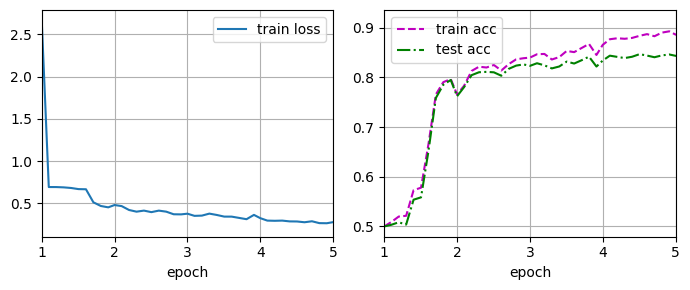

In [72]:
model = train_classifier(model, train_iter, test_iter, Epochs=5, lr=0.01, verbose=20)

接下来，我们可以创建预测函数 `predict_sentiment`，来预测文本的情绪了

In [85]:
def predict_sentiment(model, vocab, sentence):
    sentence = tf.constant(vocab[utils.english_tokenize(sentence, token="word")], dtype=tf.int32)
    label = tf.argmax(model(sentence), axis=1)[0]
    return "positive" if label == 1 else "negative"

In [86]:
ch7.predict_sentiment(model, vocab, ["this movie is so great"])

'positive'

In [87]:
ch7.predict_sentiment(model, vocab, ["what a terrible experience"])

'negative'

----

**(2) 使用卷积神经网络 CNN**

在学习图像特征提取时，我们引入了**卷积神经网络 CNN**，它通过一个**二维卷积核**在**二维的图像输入**上滑动，不断聚合的提取特征，事实上，我们可以非常简单地**把卷积神经网络推广到处理一维的序列**
* 在二维图像输入中，每个像素作为一个个体，拥有一组特征表示，即**通道维度**，对于一维的序列，每个时间步的词元作为一个个体，同样拥有一组特征表示，即**词嵌入向量**
* 在二维图像中，**二维卷积核向左向下**不断滑动提取特征，在一维序列中，我们可以使用**一维卷积核**从序列的**开始到结尾滑动**不断提取特征，因此这是一种**一维卷积**
  * **所有与卷积相关的概念都可以平行推广**，例如卷积核尺寸，步幅，填充，多输入多输出通道等等
* 在二维 CNN 中，我们通过最大池化 / 平均池化来从特征图上提取关键信息，**在一维 CNN 中，最大池化和平均池化也依然使用**
  * 以**最大池化**为例，结合**情感分析**，我们可以将该算子理解为，**提取一段文本序列中最重要的词元**，往往一句话的情绪仅有几个关键的词元决定（否定和肯定词，或者是形容词）
  * 这种针对一维文本序列的池化操作，可以看作是**时间汇聚层**，他**在时间维度上聚合信息**

因此，保持词嵌入模型不变，更改中间的 RNN 模型为 CNN 模型，得到新的模型架构如下：

<img src="../source/Chap7/nlp-情感分析CNN.svg" width=700>

具体到 CNN 的设计，在 CNN 一章中我们看到了多样的卷积特征提取器的设计方案，针对一维卷积，这里我们介绍一种比较简单和实用的结构 `textCNN`，对于具有 $d$ 维向量表示的 $n$ 哥词元的文本序列，`textCNN` 模型的计算如下图所示：
* 定义**多个一维卷积核**，对输入执行卷积运算，具有**不同宽度的卷积核可以捕获不同数据的相邻词元之间的局部特征**
* 多每个卷积的运算结果，在输出通道维度上执行**最大时间汇聚**，得到多个**只包含通道维度的一维向量表示**
* 将得到的**向量进行拼接**，最后**接入下游的全连接网络**，构建分类器

<img src="../source/Chap7/textCNN.svg" width=700>

下面，我们来定义 `textCNN` 模型
* 与前面的 `SentimentRNN` 稍有不同，我们在下游任务的分类器中加入了 `Dropout` 层，以缓解过拟合

In [93]:
class textCNN(tf.keras.Model):
    def __init__(self, vocab_size : int, embed_size : int, 
                 kernel_sizes : list, num_channels : list, *args, **kwargs):
        super(textCNN, self).__init__(*args, **kwargs)
        # 嵌入层
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        # 定义多组卷积层
        self.convs = []
        for num_channel, kernel_size in zip(num_channels, kernel_sizes):
            self.convs.append(tf.keras.layers.Conv1D(num_channel, kernel_size))
        # 定义池化层
        self.pool = tf.keras.layers.GlobalMaxPool1D()

        # 下游任务网络，二分类
        self.decoder = tf.keras.models.Sequential([
            tf.keras.layers.Dropout(0.5), # dropout 减少过拟合
            tf.keras.layers.Dense(2, activation="softmax")
        ])
    
    def call(self, X, *args, **kwargs):
        # X 的形状: (batch_size, num_steps)
        # 先做词嵌入
        X = self.embedding(X) # 形状: (batch_size, num_steps, embed_size)
        # 进行卷积和池化，并进行拼接
        X = tf.concat([self.pool(conv(X)) for conv in self.convs], axis=1)
        X = tf.nn.relu(X) # 做一次 relu 激活，形状：(batch_size, sum(num_channels))

        # 接入全连接层进行分类
        return self.decoder(X,**kwargs)

接下来，我们创建模型，同样将 `GloVe` 预训练模型的参数导入，并冻结嵌入层

In [94]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
num_steps = 300
model = textCNN(len(vocab), embed_size, kernel_sizes, nums_channels)
model.build(input_shape=(None, num_steps))
# 设置 Embedding 层的权重，并冻结
model.embedding.set_weights([embed_weights])
model.embedding.trainable = False

使用相同的接口进行训练，并评估，这与 `SentimentRNN` 没有区别

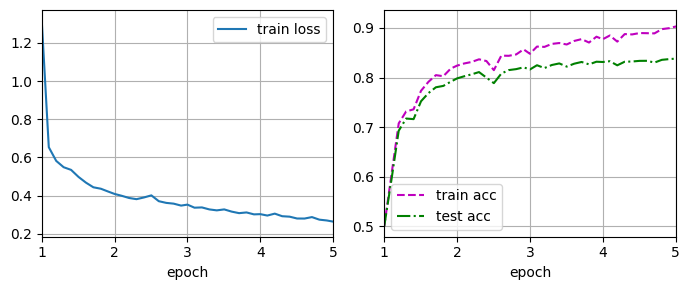

In [95]:
model = ch7.train_classifier(model, train_iter, test_iter, Epochs=5, lr=0.001, verbose=20)

In [96]:
ch7.predict_sentiment(model, vocab, ["this movie is so great"])

'positive'

In [101]:
ch7.predict_sentiment(model, vocab, ["i won't watch this movie again ! it's so boring"])

'negative'

----

### **7.4.2 多文本任务**

情感分析任务每次只关注一条文本序列，而有的 NLP 任务可能需要联系多条文本才能完成，例如下面展示的**自然语言推断**
* 自然语言推断的任务是，判断**假设**是否可以从**前提**中推断出来，**假设和前提都是文本序列**，自然语言推断决定了**一对文本序列之间的逻辑关系**，这可以分为**三种类型**：
  * **蕴含 (entailment)**：假设可以从前提推断出来，例如：
    * 前提：他们牵手走在海边
    * 假设：他们可能是情侣
  * **矛盾 (contradiction)**：假设的否定形式可以从前提推断出来，例如：
    * 前提：一只柴犬正兴奋地跑向它的主人
    * 假设：这只柴犬在睡觉
  * **中性 / 无关 (neutral)**：其他所有情况，例如：
    * 前提：他们正在舞台上跳舞
    * 假设：他们是大学生

我们以斯坦福大学的自然语言推断数据集 `SNLI` 为例，它包含 500000 多个带标签的英文句子对，存放路径 `../source/data/text/snli/`，目录结构为：
* `snli`
  * `snli_1.0_train.txt`
  * `snli_1.0_test.txt`
  
`SNLI` 的文本中**每个单词都被括号** `()` **包裹**，并有**多个空格将单词隔开**，可以**先用正则表达式对每个句子做预处理**
* 每一行样本包含了**标签、前提和假设**，它们可以用 `"\t"` 来进行分割

In [4]:
def read_snli(path : str, dataset : str="train"):
    import re
    def extract_text(s):
        # 去掉无用的括号
        s = re.sub('\\(', '', s)
        s = re.sub('\\)', '', s)
        # 将连续的多个空格替换成一个空格
        s = re.sub('\\s{2,}', ' ', s)
        return s.strip()

    labels_dict = {"entailment": 0, "contradiction": 1, "neutral": 2}
    dataset = "snli_1.0_{}.txt".format(dataset)
    path = os.path.join(path, dataset)
    with open(path, "r") as f:
        # 跳过第一行，并用 \t 分割，得到前提、假设和标签
        lines = [line.split('\t') for line in f.readlines()[1:]]
    
    # line[0] 是标签，line[1] 是前提，line[2] 是假设
    premises = [extract_text(line[1]) for line in lines if line[0] in labels_dict] # 前提
    hypotheses = [extract_text(line[2]) for line in lines if line[0] in labels_dict] # 假设
    labels = [labels_dict[line[0]] for line in lines if line[0] in labels_dict] # 标签
    
    return premises, hypotheses, labels

In [5]:
path = "../source/data/text/snli/"
premises, hypotheses, labels = read_snli(path,dataset="train")
print("样本量：", len(premises))
for i in range(3):
    print("前提：", premises[i])
    print("假设：", hypotheses[i])
    print("标签：", labels[i])

样本量： 549367
前提： A person on a horse jumps over a broken down airplane .
假设： A person is training his horse for a competition .
标签： 2
前提： A person on a horse jumps over a broken down airplane .
假设： A person is at a diner , ordering an omelette .
标签： 1
前提： A person on a horse jumps over a broken down airplane .
假设： A person is outdoors , on a horse .
标签： 0


#### **数据集预处理**

与所有 NLP 任务类似，我们需要通过填充和截断，创建批量数据迭代器

In [33]:
class SNLIDataloader:
    def __init__(self, path : str, dataset : str, num_steps : int, vocab=None) -> None:
        self.num_steps = num_steps
        # 读取训练数据集
        data = read_snli(path, dataset)
        # 对文本进行词元化
        self.premises = utils.english_tokenize(data[0], token="word")
        self.hypotheses = utils.english_tokenize(data[1], token="word")
        self.labels = tf.constant(data[2])
        # 创建词表
        if vocab is None:
            self.vocab = utils.Vocab(self.premises + self.hypotheses, min_freq=5)
        else:
            self.vocab = vocab

        # 进行填充和截断
        self.premises = self.pad_func(self.premises)
        self.hypotheses = self.pad_func(self.hypotheses)
    
    # 填充和阶段辅助函数
    def pad_func(self, X):
        return tf.constant([
            utils.truncate_padding(self.vocab[line],self.num_steps, self.vocab["<pad>"]) for line in X])
    
    def __getitem__(self, idx):
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]
    
    def __len__(self):
        return len(self.labels)

    def create_dataset(self, batch_size, shuffle=False):
        data_iter = tf.data.Dataset.from_tensor_slices(((self.premises, self.hypotheses), self.labels))
        if shuffle:
            data_iter = data_iter.shuffle(buffer_size=len(self.labels))
        data_iter = data_iter.batch(batch_size)
        return data_iter

绘制文本序列长度的分布图，可以观察到该数据集的文本序列都较短，**几乎所有句子的长度都小于 40**，我们可以设置 `num_steps = 40`

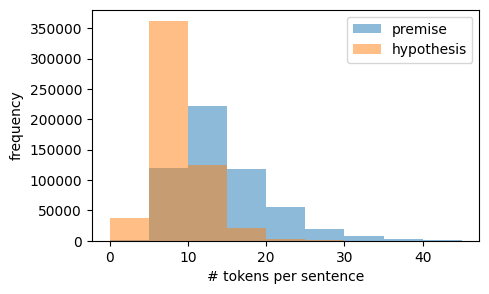

In [10]:
fig = plt.figure(figsize=(5, 3))
plt.hist([len(line.split()) for line in premises], bins=range(0, 50, 5), alpha=0.5, label="premise")
plt.hist([len(line.split()) for line in hypotheses], bins=range(0, 50, 5), alpha=0.5, label="hypothesis")
plt.xlabel("# tokens per sentence")
plt.ylabel("frequency")
plt.legend()

最后，将所有的组件进行整合，并注意**测试集数据**直接使用**训练集样本上得到的词表**，而不需要重新创建词表

In [34]:
def load_snli_dataset(path : str, num_steps : int, batch_size : int=64):
    train_data = SNLIDataloader(path, "train", num_steps)
    vocab = train_data.vocab
    # 创建测试数据集，并指定词表 vocab
    test_data = SNLIDataloader(path, "test", num_steps, vocab=vocab)
    train_iter = train_data.create_dataset(batch_size, shuffle=True)
    test_iter = test_data.create_dataset(batch_size)
    return train_iter, test_iter, vocab

我们来测试一下函数的接口工作是否正常

In [36]:
# 创建数据迭代器
path = "../source/data/text/snli/"
train_iter, test_iter, vocab = load_snli_dataset(path, num_steps=40, batch_size=64)
for x_batch, y_batch in train_iter.take(1):
    print("前提：", x_batch[0].shape)
    print("假设：", x_batch[1].shape)
    print("标签：", y_batch.shape)

前提： (64, 40)
假设： (64, 40)
标签： (64,)


下面，我们介绍一种**基于注意力思想**的模型结构，它可以用来**处理这种文本对任务**，与前面情感分析介绍的模型结构类似，我们首先还是需要先完成词嵌入，只需要更建模逻辑和下游任务网络即可，如下图所示：

<img src="../source/Chap7/nlp-attention.svg" width=700>

在模型架构的设计上，我们可以**让前提和假设中的词元进行对齐**，然后**比较和聚合这些信息**，最后**用聚合的信息来预测前提和假设之间的逻辑关系**，如下图所示
* **注意阶段**：在该阶段，我们**让前提** $P=[P_1,\cdots,P_m]$ **和假设** $H=[H_1,\cdots,H_n]$ **中的词元进行对齐**，例如相同的主语，相同含义的语句
  * 这种**对齐通过注意力权重的分配来建模**，是一种**软对齐**
  * 假设 $P$ 对齐到的序列为 $h=[h_1,\cdots,h_m]$，$H$ 对齐到的序列为 $p=[p_1,\cdots,p_n]$
* **比较阶段**：在该阶段，我们将原序列与其对齐后的另一个序列进行比较，比较通过一个全连接网络来实现，该过程会生成一个聚合特征
  * 即让 $P$ 和 $h$ 做比较，让 $H$ 和 $p$ 做比较
  * 假设比较函数是 $g$，则我们将要比较的两条序列在特征维度上拼接，让后得到：$C_P = g([P;h])$ 和 $C_H = g([H;p])$
* **聚合阶段**：在该阶段，我们利用 $C_P,C_H$ 通过在时间步维度求和得到更加聚合的特征，然后接入下游分类网络

<img src="../source/Chap7/使用注意力的自然语言推断.svg" width=700>

我们下面具体来看每个阶段的数学建模表述，以及它们的代码实现

**(1) 注意和对齐阶段**

我们假设 $P=[P_1,\cdots,P_m]$ 和 $H=[H_1,\cdots,H_n]$ 分别**表示前提和假设序列**，其中 $P_i,H_j\in\mathbb{R}^d$ 是嵌入后的词向量，软对齐时，**注意力分数** $a_{i,j}$ 用内积表示为：
$$
a_{i,j} = f(P_i)^T f(H_j)
$$
其中，$f$ 是一个**全连接网络**，$f$ 分别输入 $P_i,H_j$，因此只需要调用 $m+n$ 次 $f$ 的运算即可，而不是 $m\times n$ 次

随后，我们利用注意力分数和 `Softmax` 变换得到注意力权重，得到对齐后的向量 $h=[h_1,\cdots,h_m]$ 和 $p=[p_1,\cdots,p_n]$：
$$
h_i = \sum_{j=1}^{n} \frac{ \exp(a_{i,j}) }{\sum_{k=1}^{n} \exp(a_{i,k})} H_j, \quad i=1,\cdots,m \\
p_j = \sum_{i=1}^{m} \frac{ \exp(a_{i,j}) }{\sum_{k=1}^{m} \exp(a_{k,j})} P_i, \quad j=1,\cdots,n
$$

* 向量 $h$ 意味着假设 $H$ 被对齐到前提 $P$ 的每个词元
* 向量 $p$ 意味着前提 $P$ 被对齐到假设 $H$ 的每个词元

下面的 `Attend` 类实现了上述计算

In [43]:
class Attend(tf.keras.Model):
    def __init__(self, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = tf.keras.models.Sequential([
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(num_hiddens, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(num_hiddens, activation="relu")
        ])
    
    def call(self, P, H, **kwargs):
        # P, H 的形状：(batch_size, num_steps, embed_size)
        # f_P, f_H 形状: (batch_size, num_steps, hidden_size)
        f_P, f_H = self.f(P,**kwargs), self.f(H,**kwargs) 

        # 计算注意力分数，(B, m, h) @ (B, h, n) -> (B, m, n)
        score = f_P @ tf.transpose(f_H, perm=[0, 2, 1]) # 形状：(batch_size, m, n)

        # 计算前提 P 的对齐序列 h
        # (B, m, n) @ (B, n, embed_size) -> (B, m, embed_size)
        # 意味着假设 H 被对齐到前提 P 的每个词元
        h = tf.nn.softmax(score, axis=2) @ H  # 形状：(batch_size, m, embed_size)

        # 计算假设 H 的对齐序列 p
        # (B, n, m) @ (B, m, embed_size) -> (B, n, embed_size)
        # 意味着前提 P 被对齐到假设 H 的每个词元
        p = tf.nn.softmax(tf.transpose(score, perm=[0, 2, 1]), axis=2) @ P # 形状：(batch_size, n, embed_size)

        return h, p

养成好习惯，测试函数的接口工作是否正确

In [44]:
attend = ch7.Attend(num_hiddens=128)
P = tf.random.uniform((2, 10, 50))
H = tf.random.uniform((2, 8, 50))
h, p = attend(P, H)
print(h.shape, p.shape)

(2, 10, 50) (2, 8, 50)


**(2) 比较阶段**

在这个阶段，我们将**原序列与对齐后的另一个序列**进行比较，将原序列词元与对齐的词元在特征维度上拼接，然后送入一个全连接神经网络 $g$：
$$
C_{P,i} = g([P_i;h_i]),\quad i=1,\cdots,m \\
C_{H,j} = g([H_j;p_j]),\quad j=1,\cdots,n 
$$

* $C_{P,i}$ 理解为，所有假设 $H$ 中的词元与前提中的词元 $P_i$ 对齐后，并与 $P_i$ 比较后的结果
* $C_{H,j}$ 理解为，所有前提 $P$ 中的词元与假设中的词元 $H_j$ 对齐后，并与 $H_j$ 比较后的结果

下面的 `Compare` 类实现了上述功能

In [47]:
class Compare(tf.keras.Model):
    def __init__(self, num_hiddens : int, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = tf.keras.models.Sequential([
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(num_hiddens, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(num_hiddens, activation="relu")
        ])
    
    def call(self, P, H, h, p, **kwargs):
        # P, H 的形状：(batch_size, m or n, embed_size)
        # h, p 的形状：(batch_size, m or n, num_hiddens)
        
        # concat(P, h) 形状: (batch_size, m, embed_size + embed_size) -> (batch_size, m, num_hiddens)
        # concat(H, p) 形状: (batch_size, n, embed_size + embed_size) -> (batch_size, n, num_hiddens)
        C_P = self.g(tf.concat([P, h], axis=-1), **kwargs)
        C_H = self.g(tf.concat([H, p], axis=-1), **kwargs)
        return C_P, C_H

创建实例，测试函数的接口是否工作正常

In [48]:
compare = ch7.Compare(num_hiddens=128)
C_P, C_H = compare(P, H, h, p)
print(C_P.shape, C_H.shape)

(2, 10, 128) (2, 8, 128)


**(3) 聚合和并接入下游网络**

现在我们拿到两组来组前提和假设的比较向量 $C_P = [C_{P,1},\cdots,C_{P,m}],C_H = [C_{H,1},\cdots,C_{H,n}]$，我们**将这些信息在序列维度上聚合**：
$$
P_{agg} = \sum_{i=1}^{m} C_{P,i},\quad H_{agg} = \sum_{j=1}^{n} C_{H,j}
$$

最后，将这些聚合的信息在特征维度上拼接，送入给下游的分类网络，下面的 `Aggregate` 类实现了这个功能

In [49]:
class Aggregate(tf.keras.Model):
    def __init__(self, num_hiddens : int, num_classes : int, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.decoder = tf.keras.models.Sequential([
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(num_hiddens, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(num_hiddens, activation="relu"),
            tf.keras.layers.Dense(num_classes, activation="softmax")
        ])
    
    def call(self, C_P, C_H, **kwargs):
        P_agg = tf.reduce_mean(C_P, axis=1) # (batch_size, num_hiddens)
        H_agg = tf.reduce_mean(C_H, axis=1) # (batch_size, num_hiddens)
        output = self.decoder(tf.concat([P_agg, H_agg], axis=-1), **kwargs)
        return output

创建 `Aggregate` 实例，检查函数接口工作是否正常

In [50]:
aggregate = ch7.Aggregate(num_hiddens=128, num_classes=3)
output = aggregate(C_P, C_H)
print(output.shape)

(2, 3)


上面介绍的模型架构被称为**可分解注意力**，我们整合上面的三个模块，组装得到 `DecomposableAttention`

In [52]:
class DecomposableAttention(tf.keras.Model):
    def __init__(self, vocab_size : int, embed_size : int, num_hiddens : int, num_classes : int, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        # 三个步骤：注意对齐，比较，聚合
        self.attend = Attend(num_hiddens)
        self.compare = Compare(num_hiddens)
        self.aggregate = Aggregate(num_hiddens, num_classes)
    
    def call(self, X, **kwargs):
        # X 的形状：(X[0], X[1]) = (batch_size, num_steps)
        P, H = self.embedding(X[0]), self.embedding(X[1]) # (batch_size, num_steps, embed_size)
        h, p = self.attend(P, H, **kwargs)
        C_P, C_H = self.compare(P, H, h, p, **kwargs)
        output = self.aggregate(C_P, C_H, **kwargs)
        return output

下面，我们创建模型实例，并为它的嵌入层加载 `GloVe` 预训练模型参数，**这些步骤与前面的两个模型完全相同**

In [4]:
path = "../source/data/text/snli/"
train_iter, test_iter, vocab = ch7.load_snli_dataset(path, num_steps=40, batch_size=1024)
glove_embedding = ch7.TokenizerEmbedding(path="../source/data/text/GloVe/glove.6B.100d/vec.txt")
# 从 GloVe 中加载词向量
embed_weights = glove_embedding[vocab.idx_to_token]
print(embed_weights.shape)

(16676, 100)


In [5]:
model = ch7.DecomposableAttention(vocab_size=len(vocab), embed_size=100, num_hiddens=128, num_classes=3)
# 设置嵌入层权重，并冻结
model.embedding.build((None, ))
model.embedding.set_weights([embed_weights])
model.embedding.trainable = False

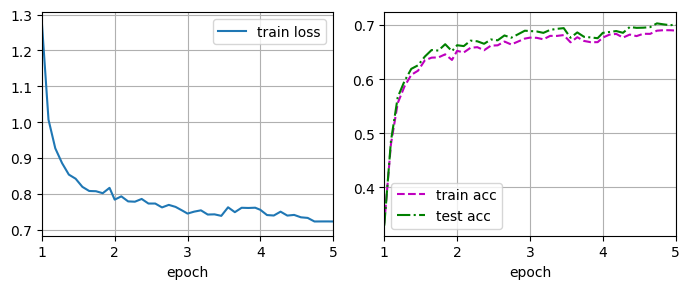

In [6]:
model = ch7.train_classifier(model, train_iter, test_iter, Epochs=5, lr=0.01, verbose=50)

我们来创建自然语言推断的预测函数 `predict_inference`

In [8]:
def predict_inference(model, vocab, premise : str, hypothesis : str):
    # 分词和转换为词索引，并添加 batch_size 维度
    premise = tf.constant(vocab[premise.lower().split()], dtype=tf.int32)[None, :]
    hypothesis = tf.constant(vocab[hypothesis.lower().split()], dtype=tf.int32)[None, :]

    # 预测
    label = tf.argmax(model([premise, hypothesis]), axis=1)[0]
    labels_dict = {0 : "entailment", 1 : "contradiction", 2 : "neutral"}
    return labels_dict[label.numpy()]

下面我们创建一个前提，然后**生成三种不同类型的假设**，测试模型是否能够正确判断

In [28]:
premise = "i see a dog running in the garden"
hypothesis = "the dog is in the garden"
predict_inference(model, vocab, premise, hypothesis)

'entailment'

In [26]:
premise = "i see a dog running in the park"
hypothesis = "the dog is inside the house"
predict_inference(model, vocab, premise, hypothesis)

'contradiction'

In [33]:
premise = "i see a dog running in the garden"
hypothesis = "the dog is black"
predict_inference(model, vocab, premise, hypothesis)

'neutral'

----

### **练习**